In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# import necessary packages

import os
import numpy as np
import pandas as pd
import cv2
import shutil
import ast
import math

import seaborn as sns
from matplotlib import pyplot as plt

from collections import defaultdict
from scipy.signal import find_peaks
import scipy
from mrmr import mrmr_classif

from sklearn.feature_selection import f_classif
from extract_feature_utils import *
from stat_vis_utils  import *
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import svm
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
# from rank import RankSVM

In [2]:
DIR_WSI = "/Users/jinzhou/Desktop/Paper_MIA/data/wsi"
DIR_ANN = "/Users/jinzhou/Desktop/Paper_MIA/data/ann_geojsons"
DIR_SAVE_RESULTS = "/Users/jinzhou/Desktop/Paper_MIA/results"
DIR_SAVE_FIGURE = "/Users/jinzhou/Desktop/Paper_MIA/results/figures"

## Process thickness.csv

In [3]:
PATH_STAT_MANUAL = os.path.join(DIR_SAVE_RESULTS, "thickness.json")

In [4]:
# read thickness analysis
def read_df_from_csv(path_csv):
    df = pd.read_json(path_csv, orient="records", lines=True)
    return df

def clean(df_thick):

    df_thick.loc[:, 'Artery_ID'] = df_thick.loc[:, 'Artery_ID'].str.split('_').str[0]        
    # Set and WSI_Artery_ID, ignoring media and intima index
    df_thick.loc[:, 'WSI_Artery_ID'] = df_thick.loc[:, 'WSI_ID'] + '_' \
        + df_thick.loc[:, 'Artery_ID']
    # For arteries with multiple lumen/intima areas, we pick the one with maxium lumen area
#     df_thick = df_thick[df_thick.loc[:, "WSI_Artery_ID"]!="11_26609_027_005 L03 TRI_A17"]        
    return df_thick

In [5]:
df_thick = read_df_from_csv(PATH_STAT_MANUAL)
df_thick = clean(df_thick)
df_thick.shape

(914, 10)

In [6]:
df_thick

,WSI_ID,Artery_ID,Thickness_Media,Thickness_Intima,Area_Media,Area_Intima,Area_Lumen,Curr_Area_Intima,Curr_Area_Lumen,WSI_Artery_ID
0,12_26609_022_015 L2 TRI,A04,"[86.3127897968, 87.5198694083, 87.4332896302, ...","[29.7984631441, 28.8300605024, 29.105177557, 2...",137268.5,30802.0,68665.0,99467.0,68665.0,12_26609_022_015 L2 TRI_A04
1,12_26609_022_015 L2 TRI,A01,"[60.4948880311, -1, -1, -1, -1, -1, -1, -1, -1...","[56.1738246003, -1, -1, -1, -1, -1, -1, -1, -1...",46182.5,18398.0,1047.5,19445.5,740.5,12_26609_022_015 L2 TRI_A01
2,12_26609_022_015 L2 TRI,A01,"[60.4948880311, -1, -1, -1, -1, -1, -1, -1, -1...","[56.1738246003, -1, -1, -1, -1, -1, -1, -1, -1...",46182.5,18398.0,1047.5,19445.5,307.0,12_26609_022_015 L2 TRI_A01
3,12_26609_022_015 L2 TRI,A02,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",158692.0,17325.5,11856.5,29182.0,11856.5,12_26609_022_015 L2 TRI_A02
4,12_26609_022_015 L2 TRI,A03,"[38.1897411248, 38.7853483174, 38.9943756351, ...","[15.6184718462, 15.6752387234, 15.3925344382, ...",32790.0,11047.0,4160.0,15207.0,4160.0,12_26609_022_015 L2 TRI_A03
...,...,...,...,...,...,...,...,...,...,...
909,12_26609_020_018 L05 A1 TRI,A13,"[150.7240471947, 147.9994050854, 148.241943737...","[202.4722214259, 202.7518723569, 201.618701646...",504109.0,351527.5,90445.5,441973.0,90445.5,12_26609_020_018 L05 A1 TRI_A13
910,12_26609_020_018 L05 A1 TRI,A17,"[44.0235723086, 44.0235148269, 44.0032857074, ...","[79.0423230086, 66.8441577006, 66.1814111086, ...",39669.5,42285.5,5814.5,48100.0,5814.5,12_26609_020_018 L05 A1 TRI_A17
911,12_26609_020_018 L05 A1 TRI,A08,"[16.5185519674, 13.9535425045, 11.5631263991, ...","[27.6288570614, 17.5126616755, 13.1389185253, ...",682589.5,410447.5,60131.5,470579.0,60131.5,12_26609_020_018 L05 A1 TRI_A08
912,12_26609_020_018 L05 A1 TRI,A04,"[138.9594238135, 140.7123996717, 142.064842213...","[173.2690059924, 169.4463377976, 166.275079706...",459949.0,251749.5,91276.5,343026.0,91276.5,12_26609_020_018 L05 A1 TRI_A04


In [7]:
# df_thick.loc[df_thick.loc[:, "WSI_Artery_ID"]=="11_26609_027_005 L03 TRI_A17", :]     

## Process "Labels.xlsx"

In [8]:
PATH_LABEL_JEFF = "/Users/jinzhou/Desktop/Paper_MIA/data/labels_jeff.csv"
PATH_LABEL_DAVID= "/Users/jinzhou/Desktop/Paper_MIA/data/labels_david.csv"

In [9]:
df_label_jeff = pd.read_csv(PATH_LABEL_JEFF).set_index("Artery_ID")
df_label_david = pd.read_csv(PATH_LABEL_DAVID).set_index("Artery_ID")

In [10]:
df_thick = df_thick.loc[df_thick.loc[:, "WSI_ID"].isin(df_label_jeff.columns), :]
print(df_thick.shape)

(914, 10)


In [11]:
df_thick = df_thick.sort_values(['Curr_Area_Intima', 'Curr_Area_Lumen'], ascending=False)
df_thick = df_thick.drop_duplicates(['WSI_Artery_ID'])

In [12]:
print(df_thick.shape)

(743, 10)


In [13]:
# count = 0
# for i, wsi_id in enumerate(df_label.columns):
#     vals = df_label.loc[:, wsi_id].values
#     count = count + np.sum(vals==0 )+ np.sum(vals==1) + np.sum(vals==2)+ np.sum(vals==3)
#     print("WSI"+str(i+1), np.sum(vals==0), np.sum(vals==1), np.sum(vals==2), np.sum(vals==3))

## Post-Processing

In [14]:
def feature_extract_all(t_multi, t_open_lumen, t_mediam, t_average):

    df_features_label = pd.DataFrame(columns = [])

    for index, row in df_thick.iterrows(): 

        # get the img
        path_artery_img = os.path.join(DIR_SAVE_FIGURE, row["WSI_ID"], row["Artery_ID"]+".png")
#         artery_img = cv2.cvtColor(cv2.imread(path_artery_img), cv2.COLOR_BGR2RGB)

        # get the measurements
        thick_media = np.array(row["Thickness_Media"])
        thick_intima = np.array(row["Thickness_Intima"])
        thick_wall = np.array([x + y if x >= 0 else x for x, y in zip(thick_media, thick_intima)])

    #     thick_wall = np.array(row["Thickness_Wall_Abs"])
        thick_media, thick_intima, thick_wall = post_process(thick_media, thick_intima, thick_wall, 
                                                            t_multi, t_open_lumen, t_mediam, t_average)
#         if -2 in thick_wall or -3 in thick_wall: # open lumen or multiple lumen/intima
#             continue
#         if -2 not in thick_wall: # open lumen or multiple lumen/intima
#             continue    
    #     plot_hist_w_two_list(thick_media, thick_intima, "Thickness", None)
        features_intima, features_media, features_ratio = extract_features(thick_media, thick_intima, thick_wall)
        row_features_label = {**features_intima, **features_media, **features_ratio}
        area_artery = row["Area_Media"] + row["Area_Intima"] + row["Area_Lumen"]
        row_features_label['Media Area'] = row["Area_Media"] / area_artery
        row_features_label['Intima Area'] = row["Area_Intima"] / area_artery
        row_features_label['Lumen Area'] = row["Area_Lumen"] / area_artery
        row_features_label['Ratio Intima/Media Area'] = row["Area_Intima"] / (row["Area_Media"] + row["Area_Intima"])
        row_features_label["WSI_ID"] = row["WSI_ID"]
        row_features_label["WSI_Artery_ID"] = row["WSI_Artery_ID"]
        
        if row["WSI_ID"] in df_label_david.columns:
            label_david = df_label_david.loc[row["Artery_ID"], row["WSI_ID"]]
            label_jeff = df_label_jeff.loc[row["Artery_ID"], row["WSI_ID"]]
            if math.isnan(label_david) or math.isnan(label_jeff):
                print("Warning", label_david, label_jeff)
                continue
            row_features_label["Label"] = label_jeff
            row_features_label["Label_Ref"] = label_david
        else:
            label_jeff = df_label_jeff.loc[row["Artery_ID"], row["WSI_ID"]]
            if math.isnan(label_jeff):
                continue
            row_features_label["Label"] = label_jeff    
        df_features_label = df_features_label.append(row_features_label, ignore_index=True)    
    return df_features_label

In [15]:
curr_max = 0
max_combo = []
t_open_lumen = 21
t_mediam = 11
t_average = 11
t_multi = 21

df_features_label = feature_extract_all(t_multi, t_open_lumen, t_mediam, t_average)

Warning 2.0 nan
Warning 2.0 nan
Warning 0 nan
Warning 1.0 nan
Warning 0.0 nan
Warning 0.0 nan
Warning 0.0 nan
Warning 0.0 nan


In [17]:
# df_features_label =  df_features_label.loc[~df_features_label.loc[:, "Label"].isna(), :]
print(df_features_label.shape)

(732, 26)


## Boxtplot and Kendall Tau Analysis

In [18]:
def violin_plots(df_features_label, feature_names):
    fig = plt.figure(figsize=(5*len(feature_names), 5))
    axs = fig.subplots(1, len(feature_names)//1)
    rhos = []
    for i, feature_name in enumerate(feature_names):
        ax_i = axs[i]

        features = df_features_label.loc[:, feature_name].values
        idx_sort = features.argsort()
        features[features>features[idx_sort][-30]] = features[idx_sort][-30]

        labels = df_features_label.loc[:, "Label"].values
        features_label_0 = features[labels==0]
        features_label_1 = features[labels==1]
        features_label_2 = features[labels==2]
        features_label_3 = features[labels==3]
        
        rho, p_val = scipy.stats.kendalltau(features, labels)
        rhos.append(rho)
        data = pd.DataFrame({'Score': labels, 'Feature Value': features})
#         sns.boxplot(x='Score', y='Feature Value', data=data, ax=ax_i)
        sns.violinplot(x='Score', y='Feature Value', data=data, ax=ax_i)
        ax_i.set_xlabel("Arteriosclerosis Score", fontsize=15)
        if i == 0:
            ax_i.set_ylabel("Feature Value", fontsize=15)
        else:
            ax_i.set_ylabel(None)
        ax_i.set_xlabel("Arteriosclerosis Score", fontsize=15)
        ax_i.set_title( feature_name + "\n" + r"$\gamma_{\tau}$" + "={:.2f}".format(rho) + " p<0.0001",
                         y=-0.4,pad=-14, fontsize=18)
    plt.tight_layout()
    plt.show()
    return rhos

In [19]:
feature_names = [x for x in df_features_label.columns if x not in ["WSI_Artery_ID", "Label"] ]
media_features = [x for x in feature_names if x.startswith("Media")]
intima_features  = [x for x in feature_names if x.startswith("Intima")]
ratio_features  = [x for x in feature_names if x.startswith("Ratio")]

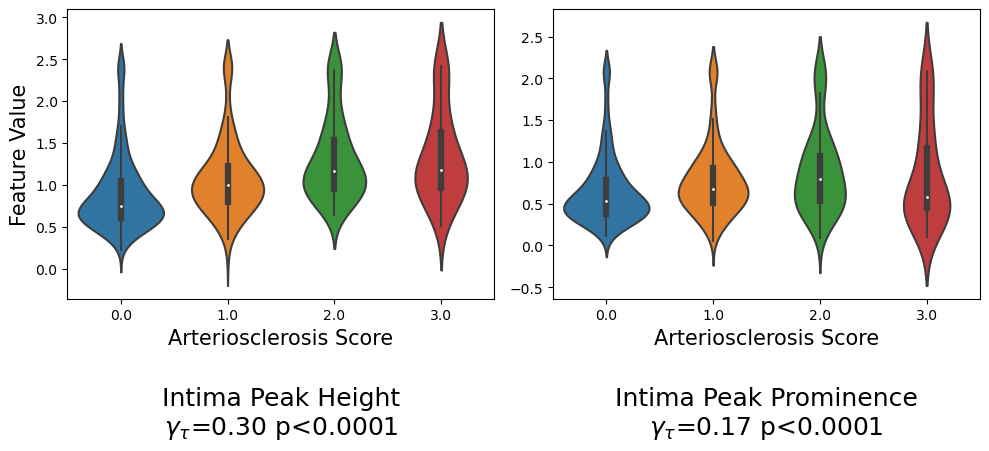

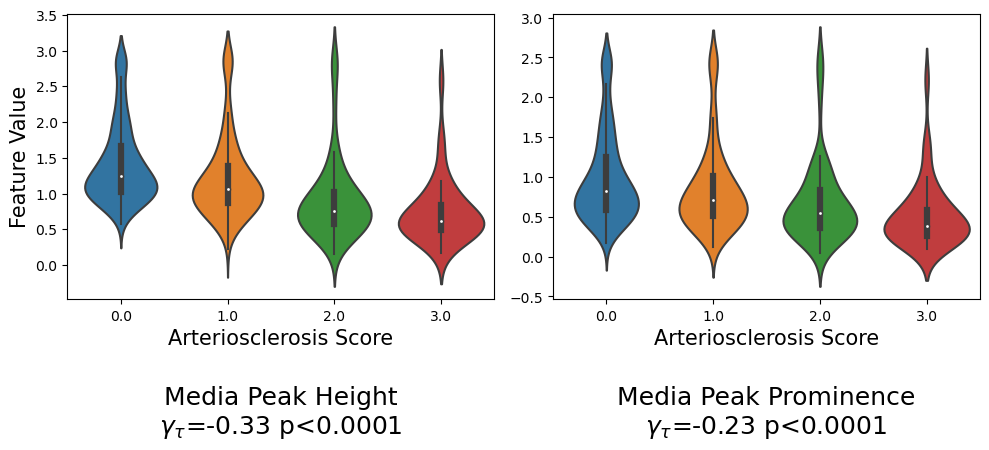

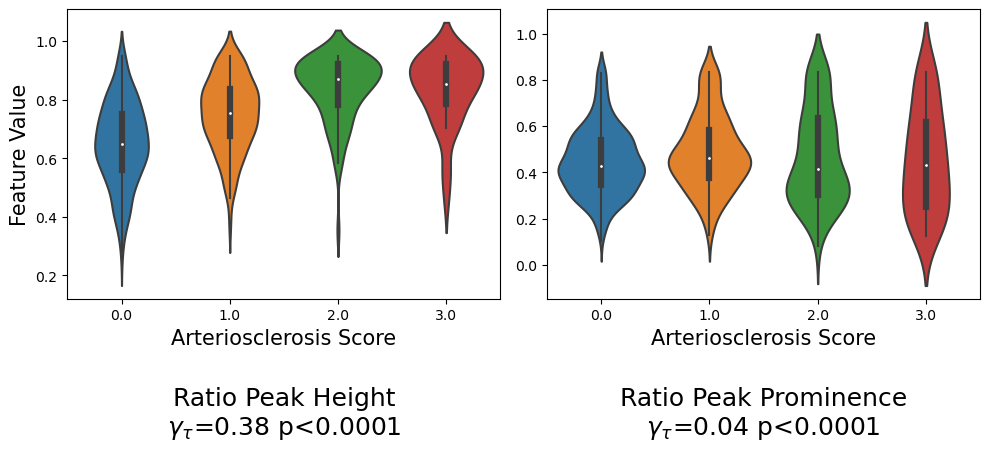

In [22]:
_ = violin_plots(df_features_label, intima_features[4:6])
_ = violin_plots(df_features_label, media_features[4:6])
_ =violin_plots(df_features_label, ratio_features[4:6])

In [ ]:
df_features_label.columns

In [ ]:
def get_clf(ml_method):    
    if ml_method == 'lr':
        clf = LogisticRegression(random_state=0, max_iter=1000)
#         clf = Ridge(random_state=0, max_iter=1000)
    elif ml_method == 'svm':
        clf = svm.SVC(decision_function_shape='ovo')
    elif ml_method == 'dt':
        clf = tree.DecisionTreeClassifier(random_state=0, max_depth=3)
    elif ml_method == 'knn':
        clf = KNeighborsClassifier(n_neighbors=10)
    return clf

In [ ]:
def train_eval(df_features_label, features, wsi_ids_train, wsi_ids_test, ref=False):
    df_features_label_train = df_features_label.loc[df_features_label.loc[:, "WSI_ID"].isin(wsi_ids_train), :]
    df_features_label_test = df_features_label.loc[df_features_label.loc[:, "WSI_ID"].isin(wsi_ids_test), :]
#     df_features_label_test =  df_features_label_test.loc[~df_features_label_test.loc[:, "Label"].isna(), :]

#         features = df_features_label_train.columns[:-8].values

    selected_features = mrmr_classif(X=df_features_label_train.loc[:, features], 
                                 y=df_features_label_train.loc[:, "Label"], K=4)
    print(selected_features)
#     selected_features = features


    X_train = df_features_label_train.loc[:, selected_features].values
    y_train = df_features_label_train.loc[:, "Label"].values

    X_test = df_features_label_test.loc[:, selected_features].values
    y_test = df_features_label_test.loc[:, "Label"].values
    

#     print(X_test.shape)

    y_test_id = df_features_label_test.loc[:, "WSI_Artery_ID"].values

    sm = RandomOverSampler(random_state=0)
    X_train_res, y_train_res  = sm.fit_resample(X_train, y_train)
#     X_train_res, y_train_res = X_train, y_train
    # clf = RankSVM()
    clf = get_clf('lr')
    clf = clf.fit(X_train_res, y_train_res)
    y_pred = clf.predict(X_test)

    if ref is True:
        y_test = df_features_label_test.loc[:, "Label_Ref"].values
        
#     print(scipy.stats.kendalltau(y_pred, y_test), balanced_accuracy_score(y_test, y_pred))
    return y_test, y_pred
#     print(cohen_kappa_score(y_pred, y_test))


In [ ]:
wsi_ids = np.unique(df_features_label.loc[:, "WSI_ID"].values)

In [ ]:
from sklearn.model_selection import KFold
def cross_val(df_features_label, features):
    kf = KFold(n_splits=4)
    kf.get_n_splits(wsi_ids)
    for i, (train_index, test_index) in enumerate(kf.split(wsi_ids)):
        wsi_ids_train = wsi_ids[train_index]
        wsi_ids_test = wsi_ids[test_index]
        _, _ = train_eval(df_features_label, features, wsi_ids_train, wsi_ids_test)

In [ ]:
features = df_features_label.columns[:-8].values
print(features)
cross_val(df_features_label, features)

In [ ]:
features = df_features_label.columns[-8:-4].values
print(features)
cross_val(df_features_label, features)

In [ ]:
features = df_features_label.columns[:-4].values
print(features)
cross_val(df_features_label, features)

In [ ]:
# wsi_ids_test = df_label_david.columns.values
# wsi_ids_test

In [ ]:
wsi_ids_test =['015_TRI_235805', '16-010-02_TRI_11632_copy',
       '16-032-02_TRI_11628_copy', '2_4827_A_0045173', '2_4839_A_0039862',
       '2_4841_A_0045207', '2_6063_A_0045151', '2_6094_A_0039851',
       '2_6097_A_0045196', '2_6128_A_0037277', '2_6130_A_0037288']

wsi_ids_train = [x for x in wsi_ids.tolist() if x not in wsi_ids_test]

In [ ]:
import itertools
def plot_confusion_matrix(y_true, label_true, y_pred, label_pred, target_names=None, path_to_save=None):

    cm = confusion_matrix(y_true, y_pred)
    cmap = plt.get_cmap('Blues')
    fig, ax  = plt.subplots(figsize=(7, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=25)
        plt.yticks(tick_marks, target_names, fontsize=25)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=25)

    plt.ylabel(label_true, fontsize=25)
    plt.xlabel(label_pred, fontsize=25)
    plt.tight_layout()
    if path_to_save:
        path_fig = os.path.join(path_to_save)
        plt.savefig(path_fig)



In [ ]:
features = df_features_label.columns[:-8].values
y_test, y_pred = train_eval(df_features_label, features, wsi_ids_train, wsi_ids_test)
y_test_ref, y_pred = train_eval(df_features_label, features, wsi_ids_train, wsi_ids_test, ref=True)


plot_confusion_matrix(y_test, "Pathologist A", y_pred, "Prediction", [0, 1, 2, 3])
plot_confusion_matrix(y_test_ref, "Pathologist B", y_pred, "Prediction", [0, 1, 2, 3])
plot_confusion_matrix(y_test, "Pathologist A", y_test_ref, "Pathologist B", [0, 1, 2, 3])

In [ ]:
features = df_features_label.columns[:-4].values
y_test, y_pred = train_eval(df_features_label, features, wsi_ids_train, wsi_ids_test)
y_test_ref, y_pred = train_eval(df_features_label, features, wsi_ids_train, wsi_ids_test, ref=True)


plot_confusion_matrix(y_test, "Pathologist A", y_pred, "Prediction", [0, 1, 2, 3])
plot_confusion_matrix(y_test_ref, "Pathologist B", y_pred, "Prediction", [0, 1, 2, 3])
plot_confusion_matrix(y_test, "Pathologist A", y_test_ref, "Pathologist B", [0, 1, 2, 3])

In [ ]:
features = df_features_label.columns[-8:-4].values
y_test, y_pred = train_eval(df_features_label, features, wsi_ids_train, wsi_ids_test)
y_test_ref, y_pred = train_eval(df_features_label, features, wsi_ids_train, wsi_ids_test, ref=True)


plot_confusion_matrix(y_test, "Pathologist A", y_pred, "Prediction", [0, 1, 2, 3])
plot_confusion_matrix(y_test_ref, "Pathologist B", y_pred, "Prediction", [0, 1, 2, 3])
plot_confusion_matrix(y_test, "Pathologist A", y_test_ref, "Pathologist B", [0, 1, 2, 3])

In [ ]:
X_train = df_features_label_train.loc[:, selected_features].values
y_train = df_features_label_train.loc[:, "Label"].values

X_test = df_features_label_test.loc[:, selected_features].values
y_test = df_features_label_test.loc[:, "Label"].values
y_test_david = df_features_label_test.loc[:, "Label_David"].values

y_test_id = df_features_label_test.loc[:, "WSI_Artery_ID"].values

In [ ]:
# from sklearn.model_selection import cross_val_score

# for ml in ['lr', 'svm', 'dt', 'knn']:
#     sm = RandomOverSampler(random_state=0)
# #     X_train_res, y_train_res  = sm.fit_resample(X_train, y_train)
# #     X_train_res, y_train_res = X_train, y_train
#     clf = get_clf(ml)
# #     clf = clf.fit(X_train_res, y_train_res)
# #     y_pred = clf.predict(X_test)
# #     print(cohen_kappa_score(y_test, y_pred))
#     print(cross_val_score(clf, X_train, y_train, cv=2))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from rank import RankSVM
sm = RandomOverSampler(random_state=0)
X_train_res, y_train_res  = sm.fit_resample(X_train, y_train)
# X_train_res, y_train_res = X_train, y_train
# clf = RankSVM()
clf = get_clf('lr')
clf = clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(scipy.stats.kendalltau(y_pred, y_test))
print(cohen_kappa_score(y_pred, y_test))

In [ ]:
print(confusion_matrix(y_test_david, y_pred))
print(scipy.stats.kendalltau(y_pred, y_test_david))
print(cohen_kappa_score(y_pred, y_test_david))

In [ ]:
print(confusion_matrix(y_test, y_test_david))
print(scipy.stats.kendalltau(y_test_david, y_test))
print(cohen_kappa_score(y_test_david, y_test))

In [ ]:
wsi_ids_test = [ '16-032-02_TRI_11628_copy', '2_4827_A_0045173', '2_4839_A_0039862',
                 '2_4841_A_0045207', '2_6063_A_0045151',
                 '2_6097_A_0045196', '2_6128_A_0037277', '2_6130_A_0037288']

# wsi_ids_test = [
#                  '2_4827_A_0045173', '2_4839_A_0039862', '2_4841_A_0045207', '2_6063_A_0045151', 
#                  '2_6094_A_0039851', '2_6097_A_0045196', '2_6128_A_0037277', '2_6130_A_0037288', ]

for wsi_id in wsi_ids_test:
#     df_features_label_train = df_features_label.loc[~df_features_label.loc[:, "WSI_ID"].isin([wsi_id]), :]
    df_features_label_test = df_features_label.loc[df_features_label.loc[:, "WSI_ID"].isin([wsi_id]), :]
    df_features_label_test =  df_features_label_test.loc[~df_features_label_test.loc[:, "Label_David"].isna(), :]
    X_test = df_features_label_test.loc[:, selected_features].values
    y_test = df_features_label_test.loc[:, "Label"].values
    y_test_david = df_features_label_test.loc[:, "Label_David"].values
    y_pred = clf.predict(X_test)
    print(cohen_kappa_score(y_pred, y_test_david), cohen_kappa_score(y_pred, y_test), 
          cohen_kappa_score(y_test, y_test_david))


In [ ]:
for i in range(len(y_test)):
    if y_test[i]==0 and y_pred[i]==3:
        print(i, y_test_id[i])

In [ ]:
len(y_test)

In [ ]:
scipy.stats.kendalltau(y_pred, y_test)

In [ ]:
# y_train = y_train.copy()
# y_train[y_train>=1] = 1
# y_test= y_test.copy()

# y_test[y_test>=1] = 1
# X_train_res, y_train_res = X_train, y_train
# # clf = RankSVM()
# clf = get_clf('lr')
# clf = clf.fit(X_train_res, y_train_res)
# y_pred = clf.predict(X_test)
# confusion_matrix(y_test, y_pred)

In [ ]:
cohen_kappa_score(y_test, y_pred)

In [ ]:
# df_features_label.loc[df_features_label.loc[:, "Label"]==0].sort_values("Ratio Average")[-20:]

In [ ]:
# features_compare = ["Intima Average", "Media Peak Height", "Ratio Peak Prominence"]
# violin_plots(df_features_label, features_compare)

In [ ]:
# df_features_label.loc[:, "WSI_Artery_ID"].str.split('_')

In [ ]:
# wsi_artery_ids_hist_comp = ["11_26609_027_006 L02 TRI_A07", "11_26609_009_008 L10 TRI_A01",
#                             "11_26609_098_005_L4 TRI_A09", "11_26609_020_006 A15 TRI_A22"]

# dir_to_save = "/Users/jinzhou/Desktop/Paper_MIA/paper/figs"
# for wsi_artery_id in wsi_artery_ids_hist_comp:
#     row = df_thick.loc[df_thick.loc[:, "WSI_Artery_ID"]==wsi_artery_id, :]
#     path_artery_img = os.path.join(DIR_SAVE_FIGURE, row["WSI_ID"].values[0], row["Artery_ID"].values[0]+".png")
#     thick_media = row["Thickness_Media"].values[0]
#     thick_intima = row["Thickness_Intima"].values[0]
#     thick_wall = np.array([x + y if x >= 0 else x for x, y in zip(thick_media, thick_intima)])
#     thick_media, thick_intima, thick_wall = post_process(thick_media, thick_intima, thick_wall)
#     label = df_label.loc[row["Artery_ID"], row["WSI_ID"]].values[0][0]
#     path_to_save = os.path.join(dir_to_save, wsi_artery_id+"_hist_score_"+str(int(label))+".png")
#     print(path_to_save, label)
#     plot_hist_w_two_list(thick_media, thick_intima, "Thickness", path_to_save)
#     shutil.copy(path_artery_img, os.path.join(dir_to_save, wsi_artery_id+".png"))

In [ ]:
# wsi_artery_ids_hist_comp = ["11_26609_027_006 L02 TRI_A07", "11_26609_009_008 L10 TRI_A01",
#                             "11_26609_098_005_L4 TRI_A09", "11_26609_020_006 A15 TRI_A22"]
# wsi_artery_ids_hist_comp = df_thick.loc[:, "WSI_Artery_ID"].values
# dir_to_save = "/Users/jinzhou/Desktop/Paper_MIA/paper/figs"
# for wsi_artery_id in wsi_artery_ids_hist_comp:
#     row = df_thick.loc[df_thick.loc[:, "WSI_Artery_ID"]==wsi_artery_id, :]
#     label = df_label.loc[row["Artery_ID"], row["WSI_ID"]].values[0][0]
#     if label < 2: continue

#     path_artery_img = os.path.join(DIR_SAVE_FIGURE, row["WSI_ID"].values[0], row["Artery_ID"].values[0]+".png")
#     artery_img = cv2.cvtColor(cv2.imread(path_artery_img), cv2.COLOR_BGR2RGB)
#     thick_media = row["Thickness_Media"].values[0]
#     thick_intima = row["Thickness_Intima"].values[0]
#     thick_wall = np.array([x + y if x >= 0 else x for x, y in zip(thick_media, thick_intima)])
#     thick_media, thick_intima, thick_wall = post_process(thick_media, thick_intima, thick_wall)
#     path_to_save = None
#     print(wsi_artery_id, label)
#     plt.imshow(artery_img)
#     plt.show()
#     plot_hist_w_two_list(thick_media, thick_intima, "Thickness", path_to_save)
# #     shutil.copy(path_artery_img, os.path.join(dir_to_save, wsi_artery_id+".png"))

In [ ]:
wsi_artery_ids_hist_comp = df_features_label.loc[df_features_label.loc[:, "Label"]==1].sort_values("Intima Peak Height")[-20:].loc[:, "WSI_Artery_ID"].values

In [ ]:
# wsi_artery_ids_hist_comp = ["KL-0023191_L03_TRIS_272723_A05", "11_26609_027_006 L02 TRI_A09"]
wsi_artery_ids_hist_comp = ["11_26609_009_008 L10 TRI_A47"]

dir_to_save = "/Users/jinzhou/Desktop/Paper_MIA/paper/figs"
for wsi_artery_id in wsi_artery_ids_hist_comp:
    row = df_thick.loc[df_thick.loc[:, "WSI_Artery_ID"]==wsi_artery_id, :]
    path_artery_img = os.path.join(DIR_SAVE_FIGURE, row["WSI_ID"].values[0], row["Artery_ID"].values[0]+".png")
#     artery_img = cv2.cvtColor(cv2.imread(path_artery_img), cv2.COLOR_BGR2RGB)
    
    thick_media = row["Thickness_Media"].values[0]
    thick_intima = row["Thickness_Intima"].values[0]
#     plot_two_in_one_col(thick_media, thick_intima, y_label=True)
    thick_wall = np.array([x + y if x >= 0 else x for x, y in zip(thick_media, thick_intima)])
    thick_media, thick_intima, thick_wall = post_process(thick_media, thick_intima, thick_wall, t_multi, t_open_lumen, t_mediam, t_average)
    label = df_label.loc[row["Artery_ID"], row["WSI_ID"]].values[0][0]
    thick_media, thick_intima, thick_wall = post_process(thick_media, thick_intima, thick_wall, t_multi, t_open_lumen, t_mediam, t_average)
    p_idx_medias, peak_prop_media = circular_peaks(np.array([x if x >=0 else np.nan for x in thick_media]), width_threshold=15)
    p_idx_media = p_idx_medias[np.argmax(peak_prop_media["peak_heights"])]
    p_idx_intimas, peak_prop_intima = circular_peaks(np.array([x if x >=0 else np.nan for x in thick_intima]), width_threshold=15)
    p_idx_intima = p_idx_intimas[np.argmax(peak_prop_intima["peak_heights"])]
    print(p_idx_intima)
    path_to_save = None
#     plt.imshow(artery_img)
#     plt.show()
    path_to_save = os.path.join(dir_to_save, wsi_artery_id+"_plot_score_"+str(int(label))+".png")
    plot_hist_w_two_list(thick_media, thick_intima, "Thickness", None)
#     plot_hist_w_two_list(thick_media, thick_intima, "Thickness", path_to_save)
    plot_two_in_one_col(thick_media, thick_intima, y_label=True)
#     plot_two_in_one_col(thick_media, thick_intima, y_label=True, p_idx_intima=[p_idx_intima], p_idx_media=[p_idx_media], path_to_save=path_to_save)

    print(df_features_label.loc[df_features_label.loc[:, "WSI_Artery_ID"]==wsi_artery_id, :])

In [ ]:
def plot_two_in_one_col(thick_media, thick_intima, y_label=True, p_idx_intima=None, p_idx_media=None, path_to_save=None):
    
    ratio = [x/y for x, y in zip(thick_intima, thick_media)]
    plt.figure(figsize=(10, 5)) 
    plt.plot([x if x>=0 else None for x in thick_media], label="Media")
    plt.plot([x if x>=0 else None for x in thick_intima], label="Intima")
    plt.plot([x if x>=0 else None for x in ratio], label="Intima-Media Ratio")
    
    if p_idx_media is not None:
        plt.scatter(p_idx_media, np.array(thick_media)[p_idx_media], marker="x", s=100)
    if p_idx_intima is not None:
        plt.scatter(p_idx_intima, np.array(thick_intima)[p_idx_intima], marker="x", s=100)
    discard_samples = 0
    start = None
    for i, x in enumerate(thick_intima):
        if x < 0 and start is None:
            start = i
        elif x >= 0 and start is not None:
            discard_samples += 1
            if discard_samples == 1:
                plt.axvspan(start, i-1, alpha=0.4, facecolor='gray', label="Discard")
            else:
                plt.axvspan(start, i-1, alpha=0.4, facecolor='gray')
            start = None
    
    # If the last chunk of -2 goes until the end of the list
    if start is not None:
        plt.axvspan(start, i, alpha=0.4, facecolor='gray')
     
    plt.xlabel("Angle", fontsize=20)
    plt.xticks(np.arange(0, 361, step=120), fontsize=15)
    if y_label:
        plt.yticks(ticks=np.arange(0, 2.2, step=0.4), fontsize=15)
#         plt.yticks(ticks=np.arange(0, 101, step=20), fontsize=15)
        plt.ylabel("Thickness", fontsize=20)
        plt.legend(fontsize=20, framealpha=0.5, loc='upper right')
    else:
        plt.yticks(ticks=np.arange(0, 1.3, step=0.4), labels=[], fontsize=20)
    if path_to_save:
        plt.savefig(path_to_save)
    plt.show()


In [ ]:
df_features_label.loc[df_features_label.loc[:, "WSI_Artery_ID"]==wsi_artery_id, "Label"]